#import python packages

In [145]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import nltk
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D

#Read dataset as json file

In [146]:
with open("dataset/guci_intent.json") as diabetes_dataset:
  dataset = json.load(diabetes_dataset)

In [147]:
def processing_json_dataset(dataset):
  tags = []
  inputs = []
  responses={}
  for intent in dataset['intents']:
    responses[intent['intent']]=intent['responses']
    for lines in intent['text']:
      inputs.append(lines)
      tags.append(intent['intent'])
  return [tags, inputs, responses]

In [148]:
[tags, inputs, responses] = processing_json_dataset(dataset)

#dataset as DataFrame

In [149]:
dataset = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [150]:
dataset.head()

,inputs,tags
0,Assalamu'alaikum,Basic
1,mikum,Basic
2,ass,Basic
3,assalamu'alaikum wr.wb,Basic
4,.,Basic


In [151]:
dataset = dataset.sample(frac=1)

In [152]:
dataset.head()

,inputs,tags
1,mikum,Basic
0,Assalamu'alaikum,Basic
2,ass,Basic
3,assalamu'alaikum wr.wb,Basic
4,.,Basic


#Pre-processing text of dataset

In [153]:
import string
dataset['inputs'] = dataset['inputs'].apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])

In [154]:
dataset.head()

,inputs,tags
1,"[m, i, k, u, m]",Basic
0,"[a, s, s, a, l, a, m, u, a, l, a, i, k, u, m]",Basic
2,"[a, s, s]",Basic
3,"[a, s, s, a, l, a, m, u, a, l, a, i, k, u, m, ...",Basic
4,[],Basic


In [155]:
dataset['inputs'] = dataset['inputs'].apply(lambda wrd: ''.join(wrd))

In [156]:
dataset.head()

,inputs,tags
1,mikum,Basic
0,assalamualaikum,Basic
2,ass,Basic
3,assalamualaikum wrwb,Basic
4,,Basic


In [157]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset['inputs'])
train = tokenizer.texts_to_sequences(dataset['inputs'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])

In [158]:
len(features[0])

2

In [159]:
input_shape = features.shape[1]
print(input_shape)

2


In [160]:
features.shape

(5, 2)

In [161]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  4
output length:  1


In [162]:
tokenizer.word_index

{'assalamualaikum': 1, 'mikum': 2, 'ass': 3, 'wrwb': 4}

#RNN MODEL

## Build RNN Model

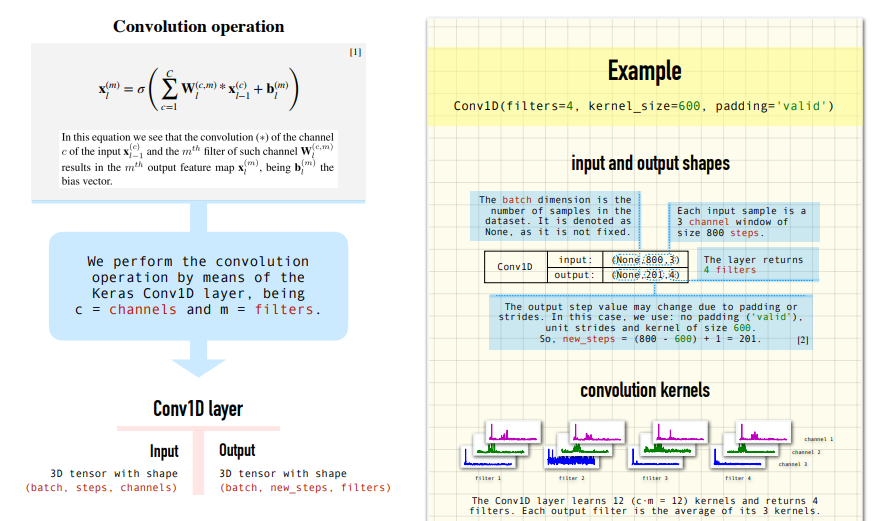

In [163]:
m = Sequential()
m.add(Input(shape=(features.shape[1],)))
m.add(Embedding(vocabulary + 1,50))
m.add(Conv1D(filters=32, kernel_size=2, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.3))
m.add(LSTM(32, dropout=0.3,return_sequences=True))
m.add(LSTM(16, dropout=0.3,return_sequences=False))
m.add(Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.6))
m.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

In [164]:
m.layers

[<Embedding name=embedding_6, built=True>,
 <Conv1D name=conv1d_6, built=True>,
 <Dropout name=dropout_8, built=True>,
 <LSTM name=lstm_8, built=True>,
 <LSTM name=lstm_9, built=True>,
 <Dense name=dense_8, built=True>,
 <Dropout name=dropout_9, built=True>,
 <Dense name=dense_9, built=True>]

In [165]:
glove_dir = "glove/glove_50dim_wiki.id.case.text.txt"
embeddings_index = {}
file_ = open(glove_dir, encoding="utf8")
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 370013 word vectors.


In [166]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,50)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [167]:
m.layers[0].set_weights([embedding_matrix])
m.layers[0].trainable = False

In [168]:
m.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [169]:
m.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 2, 50)          │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1, 32)          │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 1, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,243 (67.36 KB)

 Trainable params: 16,993 (66.38 KB)

 Non-trainable params: 250 (1000.00 B)

In [170]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)

In [171]:
history_training = m.fit(features,labels,epochs=2000, batch_size=64, callbacks=[ earlyStopping])

Epoch 1/2000


d:\Nova\Skripsi\tourguide\.venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0000e+00 - loss: 0.0046
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0000e+00 - loss: 0.0045
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0044
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0044
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0043
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0000e+00 - loss: 0.0042
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0000e+00 - loss: 0.0042
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0041
Epoch 9/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0041
Epoch 10/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0000e+00 - loss: 0.0040
Epoch 11/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0039
Epoch 12/2000
1/1 ━━━━━━━━━━━━━━━━

In [172]:
import matplotlib as mpl
def draw_plot(data, type_data):
  # mpl.style.use('seaborn')
  plt.figure(figsize = (25, 5))
  plt.plot(data,'darkorange', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

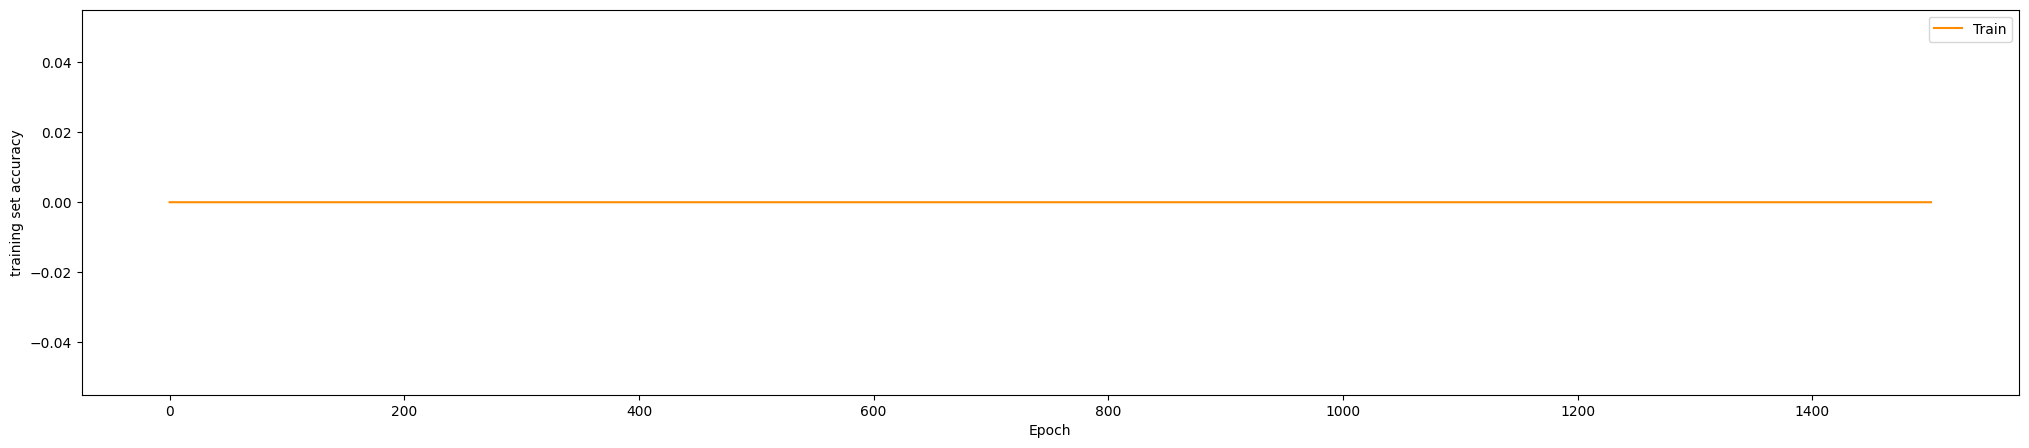

In [173]:
draw_plot(history_training.history['accuracy'],'training set accuracy' )

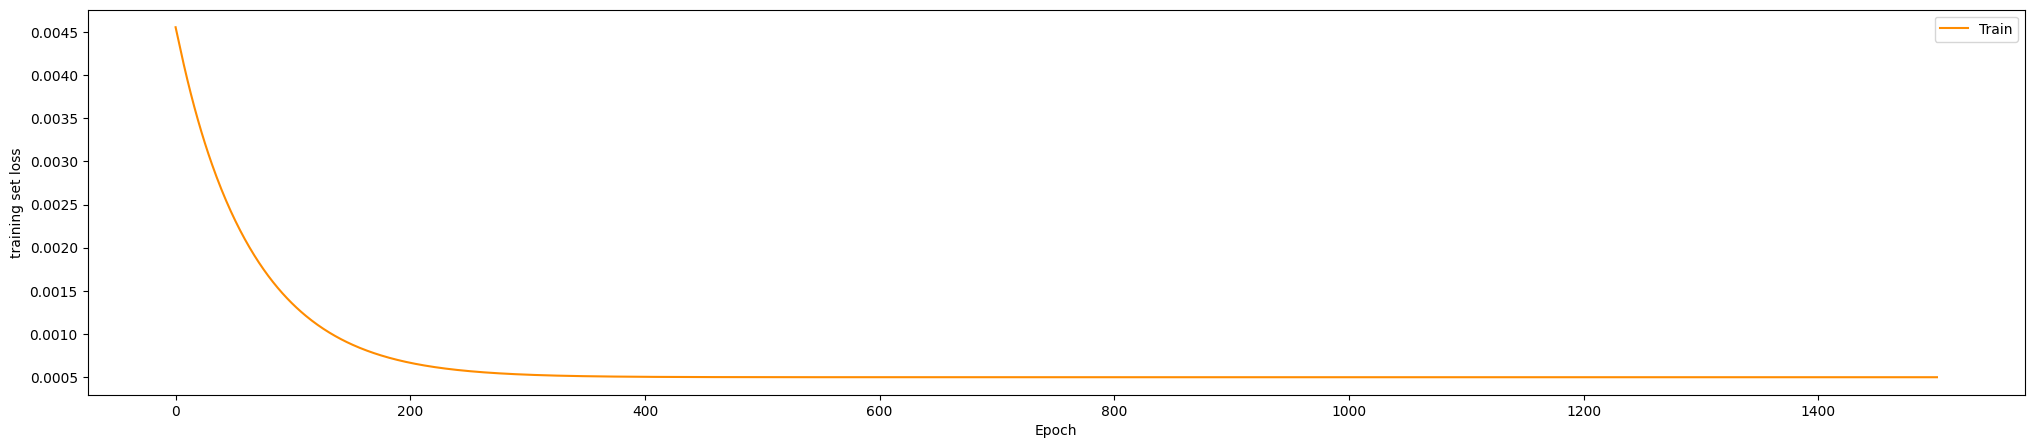

In [174]:
draw_plot(history_training.history['loss'],'training set loss' )

In [175]:
m.evaluate(features, labels, batch_size = 64)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - accuracy: 0.0000e+00 - loss: 5.0000e-04


[0.0004999999655410647, 0.0]

#Live Testing

In [176]:
import random
def generate_answer(query):
  texts = []
  pred_input = query
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],input_shape)
  output = m.predict(pred_input)
  output = output.argmax()
  response_tag = le.inverse_transform([output])[0]
  return random.choice(responses[response_tag])

In [180]:
list_que = ["ass"]
for i in list_que:
  print("you: {}".format(i))
  res_tag = generate_answer(i)
  print(res_tag)  

you: ass
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
wa'alaikumusallam wr. Wb, Apakah ada yang bisa kami bantu?tolong ketikan apa yang anda hendak kunjungi di objek wisata guci 
